<h1>Predicting Navaid Power Levels Using Signal and Operational Characteristics</h1>

<h2>1) Importing Necessary Libraries</h2>
<h3>We import libraries like pandas for data handling, numpy for numerical operations, matplotlib and seaborn for visualization, and sklearn for machine learning tasks</h3>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

<h2>2) Loading the dataset</h2>
<h3>The dataset navaids.csv is loaded into a Pandas DataFrame, allowing us to process and analyze its contents</h3>

In [2]:
df = pd.read_csv("navaids.csv")


In [3]:
df.head()

,id,filename,ident,name,type,frequency_khz,latitude_deg,longitude_deg,elevation_ft,iso_country,dme_frequency_khz,dme_channel,dme_latitude_deg,dme_longitude_deg,dme_elevation_ft,slaved_variation_deg,magnetic_variation_deg,usageType,power,associated_airport
0,85050,Williams_Harbour_NDB_CA,1A,Williams Harbour,NDB,373,52.558899,-55.782200,70.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,-23.072,LO,MEDIUM,CCA6
1,85051,Sable_Island_NDB_CA,1B,Sable Island,NDB,277,43.930599,-60.022900,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,-19.100,LO,MEDIUM,NaN
2,85052,Nanaimo_DME_CA,1CD,Nanaimo,DME,111450,49.057201,-123.872002,83.0,CA,111450.0,051Y,NaN,NaN,NaN,NaN,18.282,LO,LOW,CYCD
3,85053,Charlottetown_NDB_CA,1D,Charlottetown,NDB,346,52.775002,-56.124001,209.0,CA,NaN,NaN,NaN,NaN,NaN,NaN,-23.163,LO,LOW,CCH4
4,85054,Black_Tickle_NDB_CA,1E,Black Tickle,NDB,349,53.466702,-55.787399,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,-23.398,LO,LOW,CCE4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11010 entries, 0 to 11009
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11010 non-null  int64  
 1   filename                11010 non-null  object 
 2   ident                   10997 non-null  object 
 3   name                    11010 non-null  object 
 4   type                    11010 non-null  object 
 5   frequency_khz           11010 non-null  int64  
 6   latitude_deg            11010 non-null  float64
 7   longitude_deg           11010 non-null  float64
 8   elevation_ft            7166 non-null   float64
 9   iso_country             10995 non-null  object 
 10  dme_frequency_khz       4081 non-null   float64
 11  dme_channel             4084 non-null   object 
 12  dme_latitude_deg        225 non-null    float64
 13  dme_longitude_deg       225 non-null    float64
 14  dme_elevation_ft        214 non-null  

<h2>Data Distribution and Exploration</h2>

<h3>A) Histogram of features</h3>
<h4>Helps visualize the distribution of numerical variables.</h4>

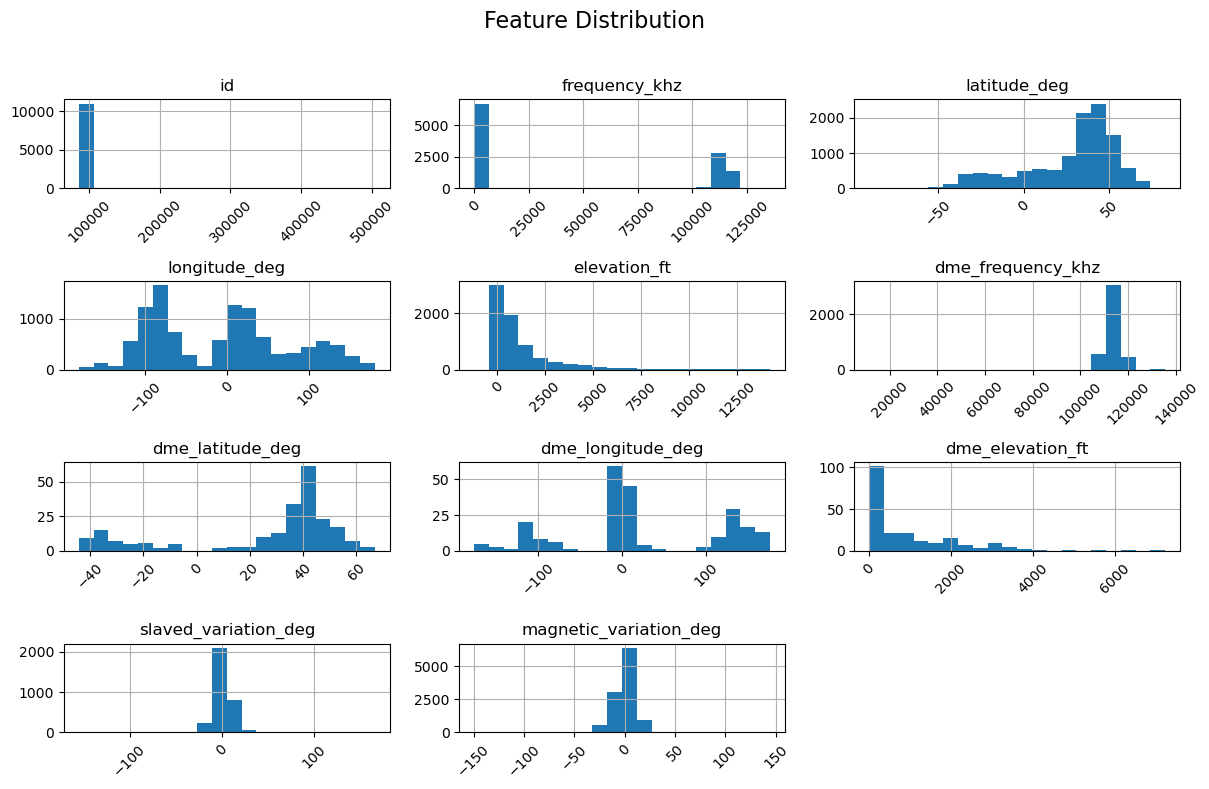

In [5]:
# Create histograms with better spacing and grid lines
df.hist(figsize=(12, 8), bins=20, grid=True)  # Set grid=True to show grid lines

plt.suptitle("Feature Distribution", fontsize=16)

# Rotate x-axis labels for better readability
for ax in plt.gcf().axes:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Adjust layout to fit everything properly
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


<h3>B) Boxplot to check outliers</h3>
<h4>Identifies the presence of outliers in numerical columns.</h4>

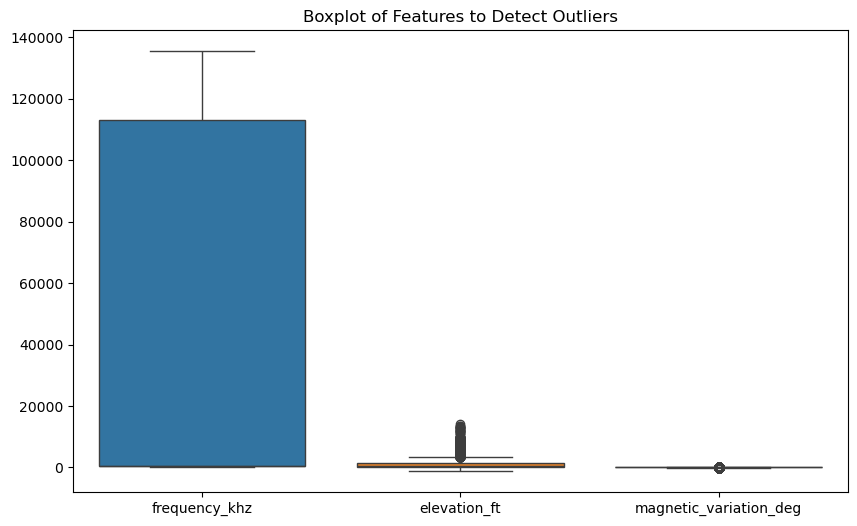

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['frequency_khz', 'elevation_ft', 'magnetic_variation_deg']])
plt.title("Boxplot of Features to Detect Outliers")
plt.show()

<h2>3) Data Cleaning and preprocessing</h2>
<h3>
We select important columns, remove missing values, and filter out invalid entries to ensure high-quality data for training.</h3>

In [7]:
df = df[['frequency_khz', 'elevation_ft', 'magnetic_variation_deg', 'power']]
df = df.dropna()
df = df[df['power'] != 'UNKNOWN']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7143 entries, 0 to 11009
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   frequency_khz           7143 non-null   int64  
 1   elevation_ft            7143 non-null   float64
 2   magnetic_variation_deg  7143 non-null   float64
 3   power                   7143 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 279.0+ KB


<h2>Feature Relationships</h2>

<h3>A) Pairplot of important features</h3>
<h4>Shows relationship between variables and scatter plots.</h4>

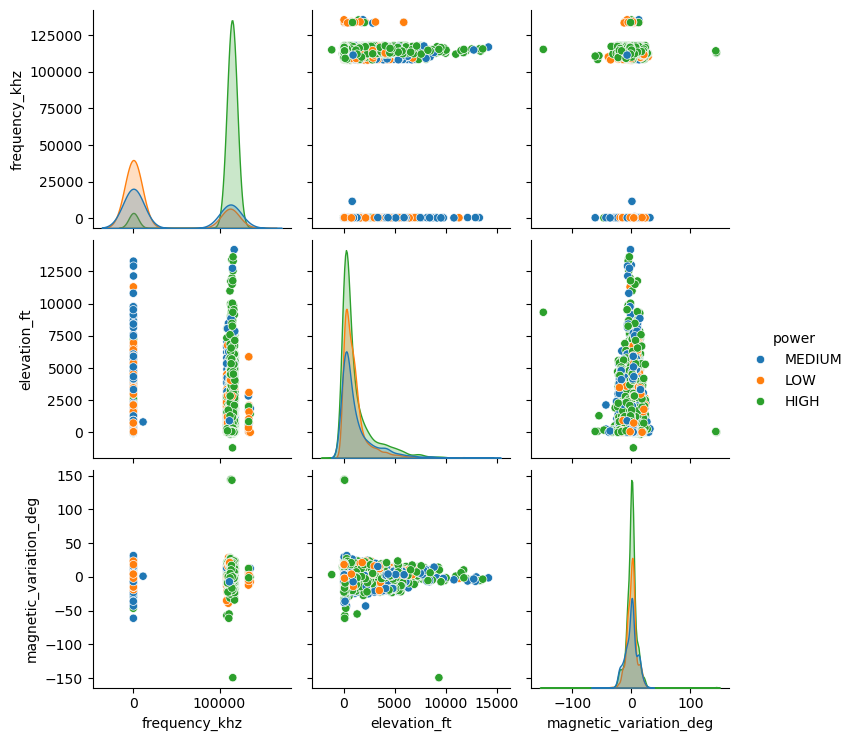

In [9]:
sns.pairplot(df, hue='power', diag_kind='kde')
plt.show()

<h3>B) Correlation heatmap</h3>
<h4>Helps understand how different numerical features are correlated.</h4>

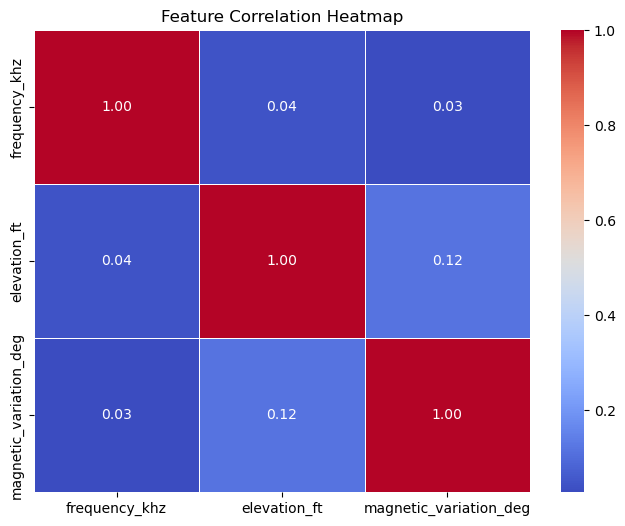

In [10]:
# Convert categorical variables to numerical
df_numeric = df.select_dtypes(include=[np.number])  # Select only numeric columns

# Compute correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

<h2>Class Distribution </h2>

<h3>A) Bar plot of power categories</h3>
<h4>Helps see how the power levels are distributed in the dataset.</h4>

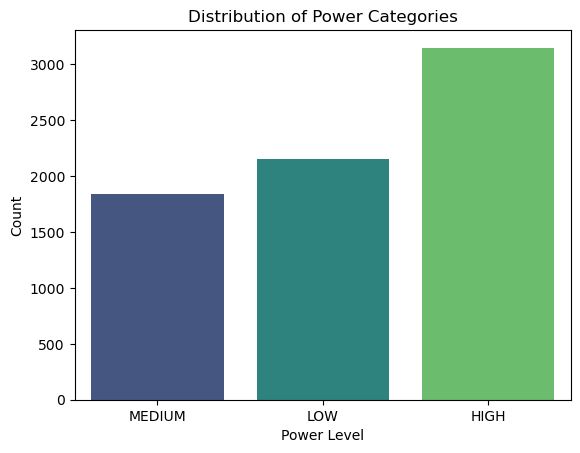

In [11]:
sns.countplot(x=df['power'], hue=df['power'], palette="viridis", legend=False)
plt.title("Distribution of Power Categories")
plt.xlabel("Power Level")
plt.ylabel("Count")
plt.show()

<h3>B) Pie chart for power classes</h3>

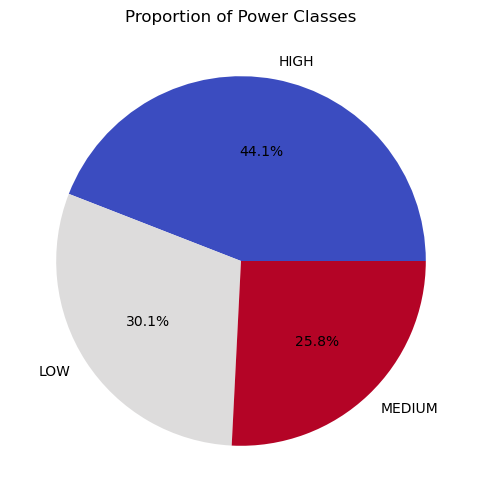

In [12]:
df['power'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6), cmap='coolwarm')
plt.title("Proportion of Power Classes")
plt.ylabel("")
plt.show()

<h2>4) Encoding categorical labels</h2>
<h3>Since machine learning models work with numerical data, LabelEncoder converts the categorical target variable (power) into numerical form.</h3>

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['power'] = le.fit_transform(df['power'])


<h2>5) Feature Scaling (Improves Logistic Regression, helps RF too)</h2>
<h3>To ensure uniformity, StandardScaler is applied to scale numerical features, making the model training more effective.</h3>

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(df[['frequency_khz', 'elevation_ft', 'magnetic_variation_deg']])
y = df['power']


<h2>Training and Testing</h2>
<h3>The dataset is divided into 80% training and 20% testing data to train the model and evaluate its accuracy on unseen data.</h3>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2>6) Random Forest with Hyperparameter Tuning</h2>
<h3>A RandomForestClassifier is trained using GridSearchCV, which optimizes hyperparameters like n_estimators, max_depth, and min_samples_split for better performance.</h3>

In [16]:
rf = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf, params, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy')

<h2>Model Performance Visualisation</h2>


<h3>A) Feature Importance Visualization</h3>
<h4>Shows which features contribute most to the predictions</h4>

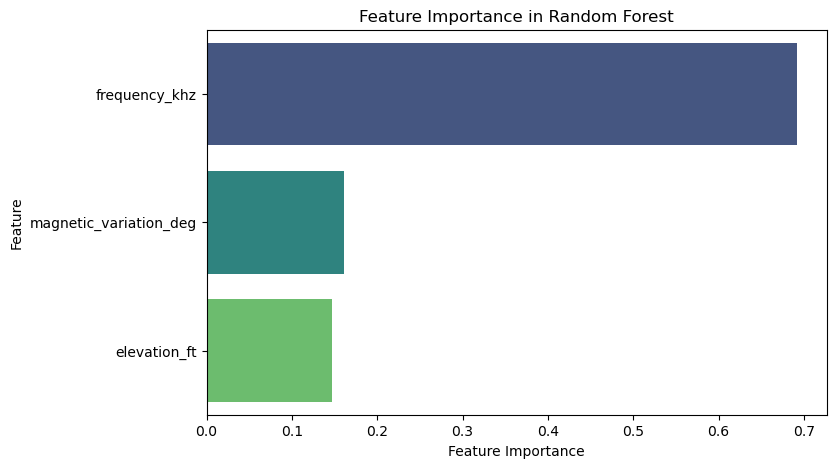

In [17]:
best_rf = grid_search.best_estimator_
feature_names = ['frequency_khz', 'elevation_ft', 'magnetic_variation_deg']
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], hue=np.array(feature_names)[indices], palette="viridis", legend=False)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.show()


<h3>B) Confusion Matrix</h3>
<h4>Visualises model performance in classification.</h4>

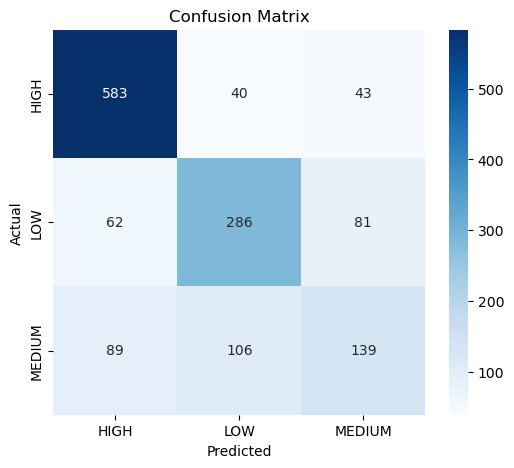

In [18]:
y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<h2>7) Model evaluation</h2>
<h3>The optimized model is used to make predictions, and its performance is evaluated using accuracy_score, which compares predicted and actual values.</h3>

In [19]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Optimized Random Forest Accuracy: {accuracy:.4f}")

Optimized Random Forest Accuracy: 0.7054


<h2>8) Predictions for new data</h2>
<h3>New input data is preprocessed and passed through the trained model to predict the corresponding power category.</h3>

In [20]:
# Example new data (Replace with actual values)
new_data = pd.DataFrame({
    'frequency_khz': [1150.0], 
    'elevation_ft': [200], 
    'magnetic_variation_deg': [5.0]
})
# Apply the same feature scaling
new_data_scaled = scaler.transform(new_data)
# Predict the class
predicted_class = best_rf.predict(new_data_scaled)
# Convert label back to original category
predicted_label = le.inverse_transform(predicted_class)
print("Predicted Power Category:", predicted_label[0])

Predicted Power Category: LOW
